In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ='whitegrid',font_scale=1)


added_features = []
def addfeature(name):
    if name not in added_features:
        added_features.append(name)
        return name
    else:
        print('Warning: feature {} overwriten'.format(name))
        return name
%matplotlib inline

In [2]:
housing= pd.read_csv('house-prices-advanced-regression-techniques/train.csv',index_col='Id')
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

### Explore the numerical attributes

In [4]:
housing_num = housing._get_numeric_data() # includes target label (Sale Price)
target = housing['SalePrice'].values

In [9]:
missing_nums = pd.DataFrame(columns=['Feature','# of missing values'])
for Feature, numNan in housing_num.isnull().sum().iteritems():
    if numNan != 0 and housing_num[Feature].dtypes!= 'object':
        missing_nums= pd.concat([missing_nums,pd.DataFrame([Feature,numNan],index=['Feature','# of missing values']).T])
missing_nums.reset_index(drop = True)

,Feature,# of missing values
0,LotFrontage,259
1,MasVnrArea,8
2,GarageYrBlt,81


In [10]:
housing_num.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### 'LotFrontage', 'GarageYrBlt', and 'MasVnrArea' are the only numerical features with missing values.

Lets check their distributions

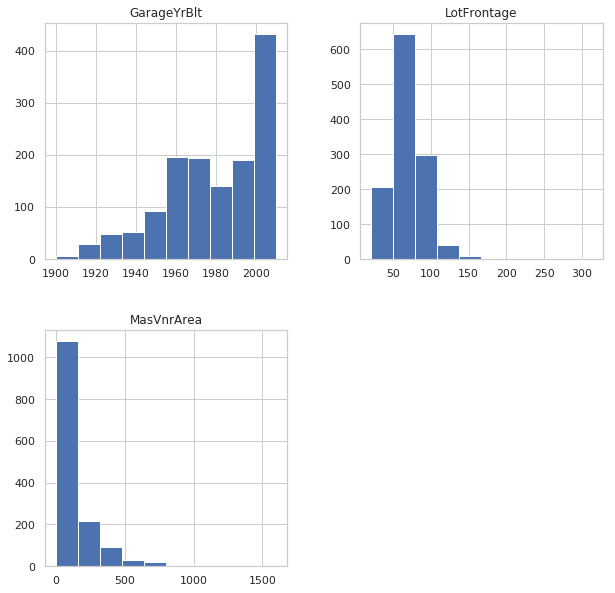

In [11]:
missing_num_attribs = ['LotFrontage','GarageYrBlt','MasVnrArea']
_=housing_num[missing_num_attribs].hist(figsize=(10,10))

In [12]:
housing_num[missing_num_attribs].median()

LotFrontage      69.0
GarageYrBlt    1980.0
MasVnrArea        0.0
dtype: float64

In this initial phase we can put the Median values, but ideally we would like to use advanced imputation methods uch as those mentioned in https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e

In [13]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)
housing_num_tr = pd.DataFrame(imputer.transform(housing_num),
                              columns=housing_num.columns,
                              index=housing_num.index)

In [14]:
print('Imputed values')
print([np.round(num,decimals=1) for i, num in enumerate(imputer.statistics_) if housing_num_tr.columns[i] in missing_num_attribs])

Imputed values
[69.0, 0.0, 1980.0]


## Distribution of the numerical features

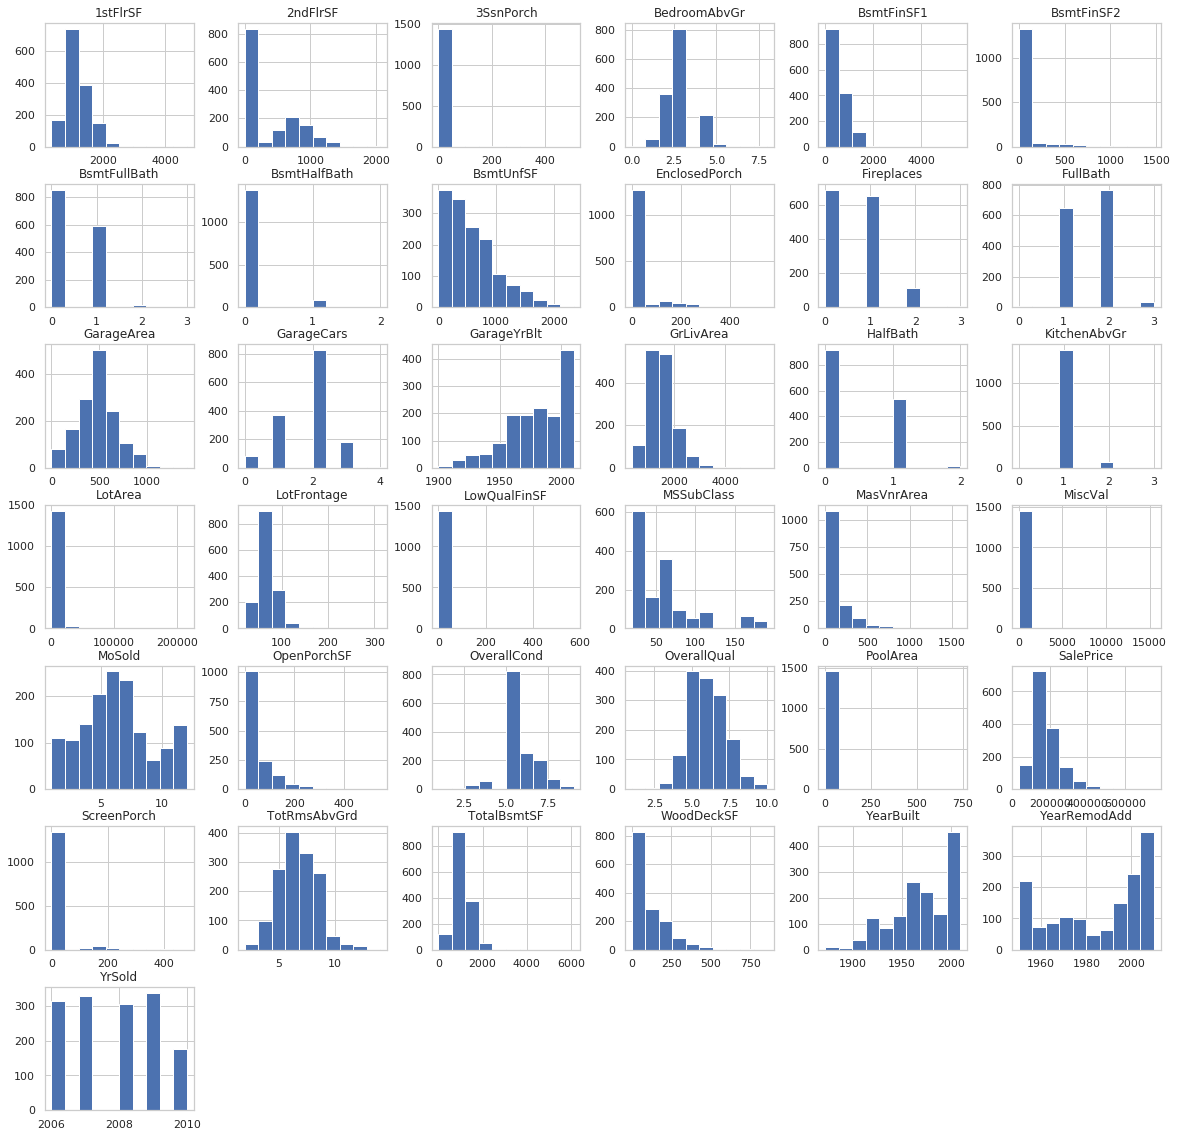

In [15]:
_=housing_num_tr.hist(figsize=(20,20))

There are several features that are not noramlly distributed, however this is not that big of a problem since the number of training instances is high. For now we won't apply any transformation.

## Correlation with SalePrice (Target)

**How strong is the monotonic relationship (assessed by Rank spearman correlation)?**

In [16]:
def corrWith(df,method='pearson',target='SalePrice'):
    '''
    methond: pearson, spearnam, and kendall
    target: feature to correlate with
    '''
    return df.corr(method=method)[target].sort_values(ascending=False)

corrWith(housing_num_tr,method='spearman')

SalePrice        1.000000
OverallQual      0.809829
GrLivArea        0.731310
GarageCars       0.690711
YearBuilt        0.652682
GarageArea       0.649379
FullBath         0.635957
TotalBsmtSF      0.602725
1stFlrSF         0.575408
YearRemodAdd     0.571159
GarageYrBlt      0.563256
TotRmsAbvGrd     0.532586
Fireplaces       0.519247
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.415906
LotFrontage      0.375590
WoodDeckSF       0.353802
HalfBath         0.343008
BsmtFinSF1       0.301871
2ndFlrSF         0.293598
BedroomAbvGr     0.234907
BsmtFullBath     0.225125
BsmtUnfSF        0.185197
ScreenPorch      0.100070
MoSold           0.069432
3SsnPorch        0.065440
PoolArea         0.058453
MSSubClass       0.007192
BsmtHalfBath    -0.012189
YrSold          -0.029899
BsmtFinSF2      -0.038806
MiscVal         -0.062727
LowQualFinSF    -0.067719
OverallCond     -0.129325
KitchenAbvGr    -0.164826
EnclosedPorch   -0.218394
Name: SalePrice, dtype: float64


**How strong is the linear relationship (pearson correlation)?**

In [17]:
corrWith(housing_num_tr)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.466754
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

## Correlation between features

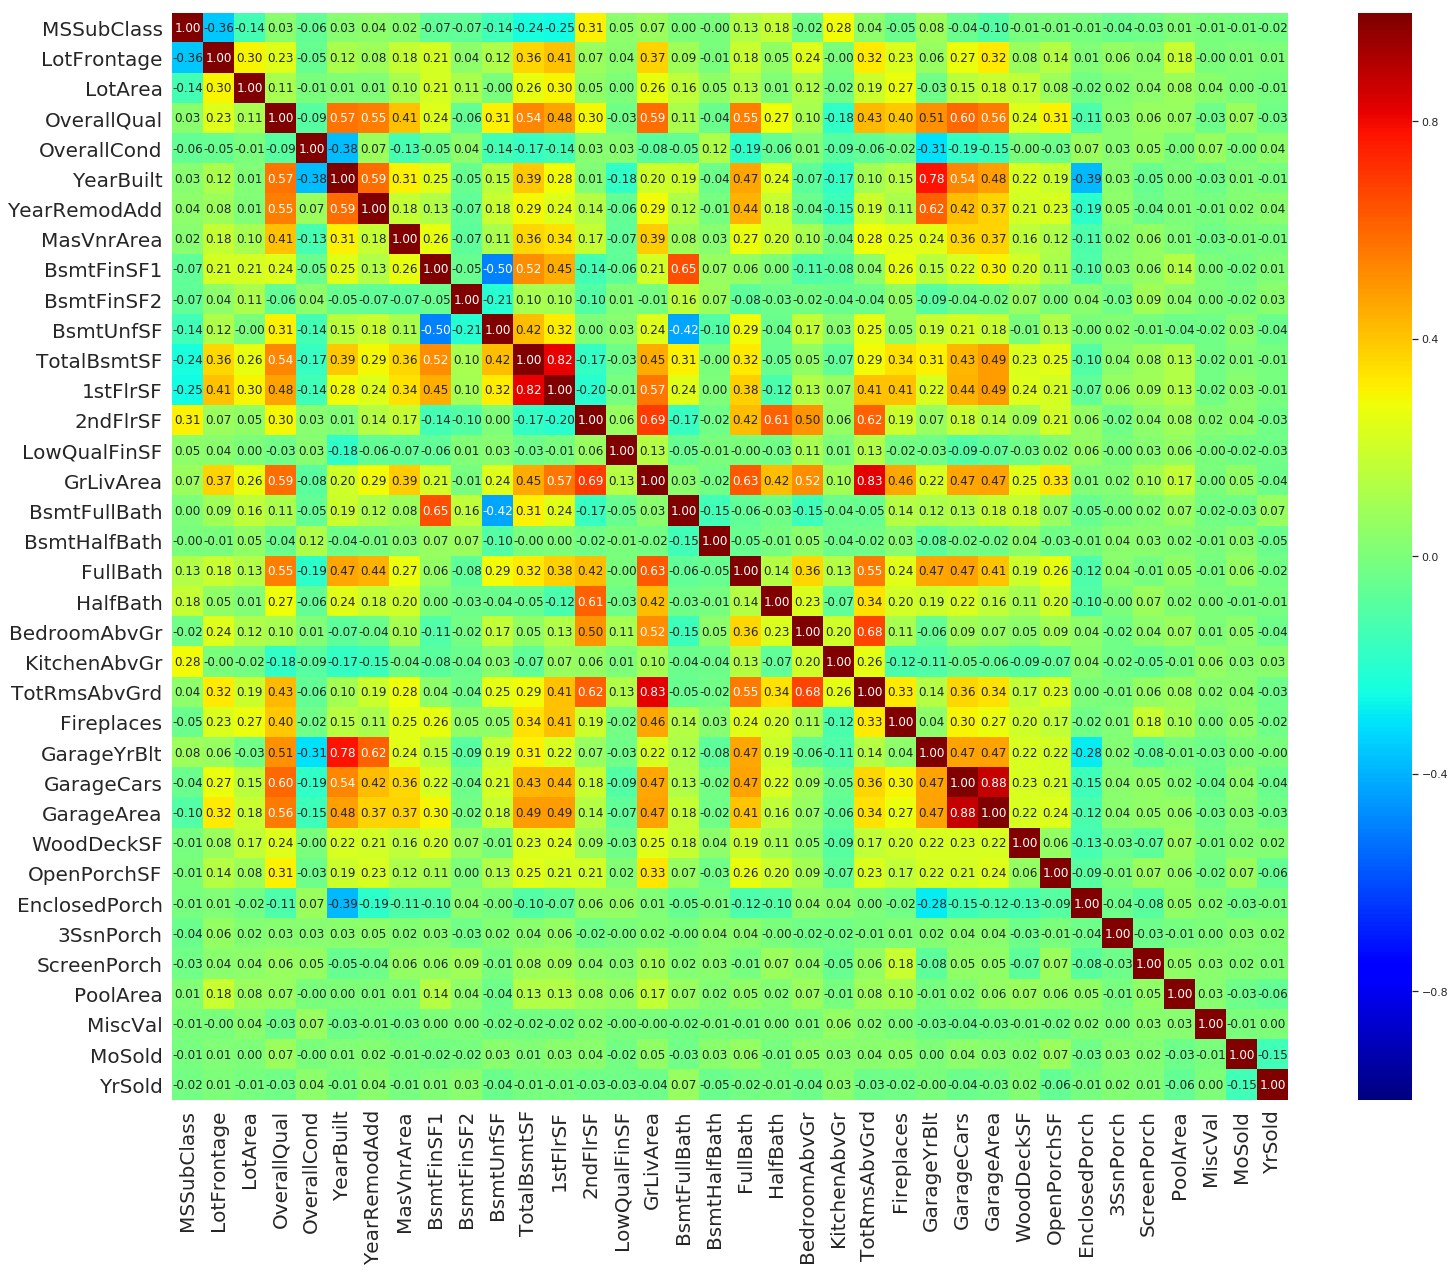

In [18]:
def plotcorrmat(df,features=None):
    plt.figure(figsize =(25,20))
    if features:
        sns.heatmap(df[features].corr(),vmin=-1,vmax=1,center=0,annot=True,cmap='jet',fmt='.2f',annot_kws=dict(size=12))
    else:
        sns.heatmap(df.drop('SalePrice',axis=1).corr(),vmin=-1,vmax=1,center=0,annot=True,cmap='jet',fmt='.2f',annot_kws=dict(size=12))
    plt.tick_params(labelsize=20)

    
plotcorrmat(housing_num_tr)

## Standardize numerical features

In [30]:
from sklearn.preprocessing import StandardScaler

In [38]:
X_num = housing_num_tr.drop('SalePrice',axis=1)

num_attribs = X_num.columns
Id = housing.index

std_scl = StandardScaler()
std_scl.fit(X_num)
X_num_std = pd.DataFrame(std_scl.transform(X_num),index=Id,columns=num_attribs)

### Explore categorical attributes

In [42]:
housing_cat = housing.drop(labels=[col for col in housing_num.columns if 'SalePrice' not in col],axis=1) # Includes target label (SalePrice)

In [43]:
missing_cat = pd.DataFrame(columns=['Feature', '# of missing vals','% of missing vals'])
for Feature, numNan in housing_cat.isnull().sum().iteritems():
    if housing_cat[Feature].dtypes == 'object' and numNan != 0:
        missing_cat = pd.concat([missing_cat,pd.DataFrame([Feature,numNan,(numNan/housing_cat.shape[0])*100],
                                                          index=['Feature', '# of missing vals','% of missing vals']).T])
missing_cat.sort_values(by=['% of missing vals'],ascending=False).reset_index(drop=True)

,Feature,# of missing vals,% of missing vals
0,PoolQC,1453,99.5205
1,MiscFeature,1406,96.3014
2,Alley,1369,93.7671
3,Fence,1179,80.7534
4,FireplaceQu,690,47.2603
5,GarageType,81,5.54795
6,GarageFinish,81,5.54795
7,GarageQual,81,5.54795
8,GarageCond,81,5.54795
9,BsmtExposure,38,2.60274



    PoolQC: NA = No Pool (ordinal)
    MiscFeature: NA = None (OneHot)
    Alley: NA = No alley access (OneHot)
    Fence: NA = No Fence (OneHot)
    FireplaceQu: NA = No fireplace (ordinal)
    GarageType: NA = No Garage (OneHot)
    GarageFinish: NA = No Garage (ordinal)
    GarageQual: NA = No Garage (ordinal)
    GarageCond: NA = No Garage (ordinal)
    BsmtFinType2: NA = No Basement (ordinal)
    BsmtQual: NA = No Basement (ordinal)
    BsmtCond: NA = No Basement (ordinal)
    BsmtFinType1: NA = No Basement (ordinal)
    MasVnrType: NA = None (OneHot)
    Electrical: NA = actually missing (no info available)
    
**Turns out there is only one categorical attribute, 'Electrical', that has missing values. All other attributes have "meaningful" missing values. For example, if a house does not have a basement, all features basements features for that house have null values.**

    Therefore, we will first impute the actual missing in Electrical feature with the most frequently occuring category, and the we will replace the meaningful missing values with "Missing"

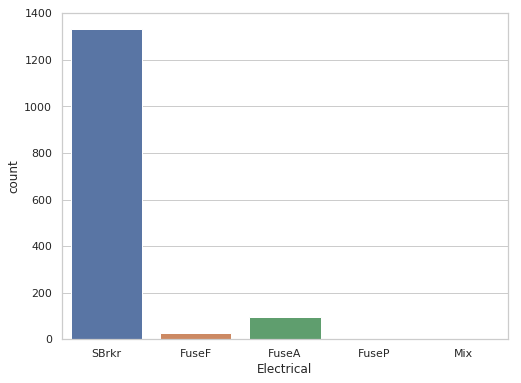

In [44]:
plt.figure(figsize=(8,6))
sns.countplot(x='Electrical',data=housing_cat)

Standard Circuit Breakers & Romex seem to be the most comman type of electrical system. Imput this for the missing rows will be safe.

In [45]:
def Impute(housing,attrib='Electrical'):
    tmp = housing.copy()
    mode = tmp[attrib].mode()[0]
    tmp[attrib] = tmp[attrib].fillna(mode)
    tmp.fillna('Missing',inplace=True)
    return tmp

In [46]:
housing_cat = Impute(housing_cat)

In [47]:
housing_cat.Electrical.unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

In [48]:
for col in housing_cat.columns:
    if housing_cat[col].dtypes == 'object':
        unique_cat = len(housing_cat[col].unique())
        print('{col}:\t\t {unique_cat} unique categories'.format(col=col,unique_cat=unique_cat))

MSZoning:		 5 unique categories
Street:		 2 unique categories
Alley:		 3 unique categories
LotShape:		 4 unique categories
LandContour:		 4 unique categories
Utilities:		 2 unique categories
LotConfig:		 5 unique categories
LandSlope:		 3 unique categories
Neighborhood:		 25 unique categories
Condition1:		 9 unique categories
Condition2:		 8 unique categories
BldgType:		 5 unique categories
HouseStyle:		 8 unique categories
RoofStyle:		 6 unique categories
RoofMatl:		 8 unique categories
Exterior1st:		 15 unique categories
Exterior2nd:		 16 unique categories
MasVnrType:		 5 unique categories
ExterQual:		 4 unique categories
ExterCond:		 5 unique categories
Foundation:		 6 unique categories
BsmtQual:		 5 unique categories
BsmtCond:		 5 unique categories
BsmtExposure:		 5 unique categories
BsmtFinType1:		 7 unique categories
BsmtFinType2:		 7 unique categories
Heating:		 6 unique categories
HeatingQC:		 5 unique categories
CentralAir:		 2 unique categories
Electrical:		 5 unique categori

In [49]:
pd.get_dummies(housing_cat['PoolQC']).head()

,Ex,Fa,Gd,Missing
Id,,,,
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,0,0,0,1


#### Cat features with missing values
    PoolQC: NA = No Pool (ordinal)
    MiscFeature: NA = None (OneHot)
    Alley: NA = No alley access (OneHot)
    Fence: NA = No Fence (OneHot)
    FireplaceQu: NA = No fireplace (ordinal)
    GarageType: NA = No Garage (OneHot)
    GarageFinish: NA = No Garage (ordinal)
    GarageQual: NA = No Garage (ordinal)
    GarageCond: NA = No Garage (ordinal)
    BsmtFinType2: NA = No Basement (ordinal)
    BsmtQual: NA = No Basement (ordinal)
    BsmtCond: NA = No Basement (ordinal)
    BsmtFinType1: NA = No Basement (ordinal)
    MasVnrType: NA = None (OneHot)
    Electrical: NA = actually missing (no info available)
    
#### Cat features with no missing values:
    MSzoning (OneHot)
    LotShape (ordinal?)
    LandContour (ordinal?)
    Utilities (OneHot)
    LotConfig (OneHot)
    LandSlope (ordinal)
    Neighborhood (OneHot)
    Condition1&2 (OneHot)
    BldgType (OneHot)
    HouseStyle (OneHot)
    RoofStyle (OneHot)
    RoofMatl (OneHot)
    Exterior1st (OneHot)
    Exterior2nd (OneHot)
    ExterQual (ordinal)
    ExterCond (ordinal)
    Foundation (OneHot)
    BsmtExposure (OneHot)
    BsmtFinType2 (ordinal)
    Heating (OneHot)
    HeatingQC (ordinal)
    CentralAir (OneHot)
    KitchenQual (ordinal)
    Functional (OneHot)
    PavedDrive (ordinal)
    MiscFeature (OneHot)
    SaleType (OneHot)
    SaleCondition (OneHot)
    

In [50]:
encoding= {'PoolQC':'ordinal','MiscFeature':'OneHot','Alley':'OneHot','Fence':'OneHot',
           'FireplaceQu':'ordinal','GarageType':'OneHot','GarageFinish':'ordinal',
           'GarageQual': 'ordinal','GarageCond':'ordinal','BsmtFinType2':'ordinal',
           'BsmtQual': 'ordinal','BsmtCond':'ordinal','BsmtFinType1':'ordinal',
           'MasVnrType': 'OneHot','Electrical':'OneHot','MSZoning': 'OneHot',
           'LotShape':'ordinal','LandContour':'ordinal','Utilities':'OneHot',
           'LotConfig':'OneHot','LandSlope':'ordinal','Neighborhood':'OneHot',
           'Condition1':'OneHot','Condition2':'OneHot','BldgType': 'OneHot','HouseStyle':'OneHot',
           'RoofStyle':'OneHot','RoofMatl':'OneHot','Exterior1st':'OneHot','Exterior2nd':'OneHot',
           'ExterQual':'ordinal','ExterCond':'ordinal','Foundation':'OneHot','BsmtExposure':'OneHot',
           'BsmtFinType2':'ordinal','Heating':'OneHot','HeatingQC':'ordinal','CentralAir':'OneHot',
           'KitchenQual':'ordinal','Functional':'OneHot','PavedDrive':'ordinal','MiscFeature':'OneHot',
           'SaleType':'OneHot','SaleCondition':'OneHot','Street':'OneHot'}

#### Lets first try OneHot encoding ALL categorical attributes

In [51]:
OneHot_cat_attribs= pd.get_dummies(housing_cat[[col for col,kind in encoding.items()]],drop_first=True)

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer

In [53]:
num_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('std_sclr',StandardScaler()),
    ('to_df',FunctionTransformer(pd.DataFrame,validate=False,kw_args={'columns':num_attribs,'index':Id}))
])
cat_pipeline = Pipeline([
    ('Impute_missing', FunctionTransformer(Impute,validate=False,kw_args={'attrib':'Electrical'})),
    ('oneHot',FunctionTransformer(pd.get_dummies,validate=False,kw_args={"drop_first":True}))
])
cat_attribs = [col for col,kind in encoding.items()]

full_pipeline= ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat",cat_pipeline,cat_attribs)
])

**Test if the pipeline is working as intended. Do to so, compare manually created feature with those created by pipeline**

Manually created

In [54]:
housing_full_man = pd.concat([X_num_std,OneHot_cat_attribs],axis=1)

Created by pipelines

In [57]:
_X_num_std = num_pipeline.fit_transform(housing[num_attribs])
_OneHot_cat_attribs = cat_pipeline.fit_transform(housing[cat_attribs])

housing_half_pipelines = pd.concat([_X_num_std,_OneHot_cat_attribs],axis =1)
housing_full_pipeline = full_pipeline.fit_transform(housing)

In [59]:
print('Manual and Pipeline are identical:')
print(np.allclose(housing_full_man.values,housing_full_pipe1.values))
print('\n')
print('half pipelines and full pipeline are identical:')
print(np.allclose(housing_full_pipe1.values,housing_full_pipe2))

Manual and Pipeline are identical:
True


half pipelines and full pipeline are identical:
True


**Perfect! Pipeline seems to be working ok!**

In [60]:
housing.SalePrice.skew()

1.8828757597682129

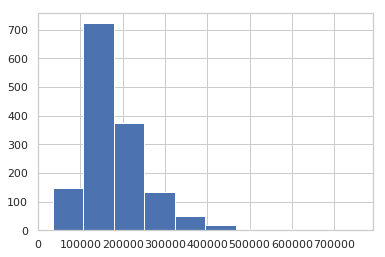

In [62]:
housing.SalePrice.hist()

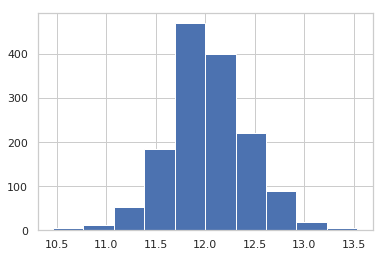

In [65]:
np.log1p(housing.SalePrice).hist()

In [67]:
np.log(housing.SalePrice).skew()

0.12133506220520406

In [68]:
np.log1p(housing.SalePrice).skew()

0.12134661989685333

In [69]:
np.log10(10)

1.0

In [81]:
np.log(1e-100+1)

0.0

In [82]:
np.log1p(1e-100)

1e-100